![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg)

![alt text](https://engmrk.com/wp-content/uploads/2018/09/LeNEt_Summary_Table.jpg)

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/folley/.pyenv/versions/3.7.9/lib/python3.7/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

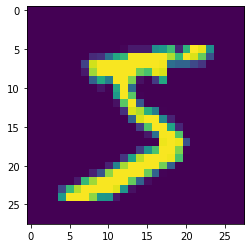

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

print(device)

cuda:0


In [11]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [12]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(2000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history.append(accuracy)    

In [13]:
lenet5.forward(X_test)

tensor([[ -1.4928,  -2.5380,   2.5561,  ...,  35.0081, -13.0895,   8.1440],
        [  7.3997,   8.8393,  37.3529,  ...,  -7.2924,   4.0722, -12.5286],
        [ -6.3275,  36.6750,  -5.6767,  ...,   0.6798,   2.6236, -11.4175],
        ...,
        [-20.4682,  -1.4050, -20.1253,  ...,  -2.6094,   3.1444,   6.2784],
        [ -3.2814, -15.0409, -23.7864,  ..., -10.6192,  15.9691,  -4.5197],
        [ -0.1878,  -7.9370,   0.2273,  ..., -19.9503,   1.4415,  -8.4296]],
       device='cuda:0', grad_fn=<AddmmBackward>)

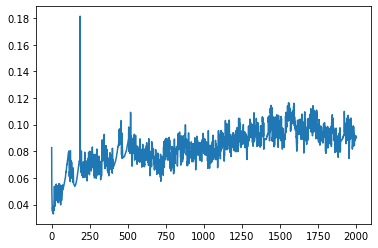

In [14]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);